In [2]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import Model
from keras.layers import Layer
from keras.callbacks import Callback
from keras import layers, regularizers, optimizers, losses, metrics, callbacks

NUM_REALIZATIONS = 1272
X_CHANNELS = 4
Y_CHANNELS = 2
NX  = 160
NY  = 160
NZ  = 5
NTT = 60
NT1 = 30
NT0 = 24

sec2year   = 365.25 * 24 * 60 * 60
Darcy      = 9.869233e-13
psi2pascal = 6894.76
co2_rho    = 686.5266
milli      = 1e-3
mega       = 1e6

In [4]:
def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[-1])
    print('-'*60+'\n')
    return None

check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.15.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [5]:
gridVE = sio.loadmat('Gt.mat', simplify_cells=True)['Gt']
tops2d = -gridVE['cells']['z'].reshape(NX,NY)
tops3d = -sio.loadmat('G.mat', simplify_cells=True)['G']['cells']['centroids'].reshape(NX,NY,NZ,3, order='F')[...,-1]

In [6]:
# Load data
X_data = np.load('data/X_data.npy')
c_data = np.load('data/c_data.npy')
y1_data = np.load('data/y1_data.npy')
y2_data = np.load('data/y2_data.npy')
timesteps = np.load('data/timesteps.npy')
print('X: {} | c: {}'.format(X_data.shape, c_data.shape))
print('y1: {} | y2: {}'.format(y1_data.shape, y2_data.shape))

X: (1271, 160, 160, 4) | c: (1271, 30, 5)
y1: (1271, 30, 160, 160, 2) | y2: (1271, 30, 160, 160, 2)


In [7]:
# Normalize data
X_data[...,0] = (X_data[...,0] - 0.10) / (0.32 - 0.10)
X_data[...,1] = np.log10(X_data[...,1] / (milli*Darcy))
X_data[...,1] = (X_data[...,1] + 0.26) / (4.0 + 0.26)
X_data[...,2] = (X_data[...,2] - X_data[...,2].min()) / (X_data[...,2].max() - X_data[...,2].min())
c_data = c_data / 10
y1_data[...,0] = y1_data[...,0] / psi2pascal / 127e3
y2_data = y2_data[...,-1]
print('X: {} | c: {}'.format(X_data.shape, c_data.shape))
print('y1: {} | y2: {}'.format(y1_data.shape, y2_data.shape))

X: (1271, 160, 160, 4) | c: (1271, 30, 5)
y1: (1271, 30, 160, 160, 2) | y2: (1271, 30, 160, 160)


In [8]:
train_idx = np.random.choice(range(len(X_data)), 1000, replace=False)
test_idx  = np.setdiff1d(range(len(X_data)), train_idx)

X_train = X_data[train_idx]
c_train = c_data[train_idx]
y1_train = y1_data[train_idx]
y2_train = y2_data[train_idx]

X_test = X_data[test_idx]
c_test = c_data[test_idx]
y1_test = y1_data[test_idx]
y2_test = y2_data[test_idx]

print('X_train:  {}     | c_train: {}'.format(X_train.shape, c_train.shape))
print('y1_train: {} | y2_train: {}'.format(y1_train.shape, y2_train.shape))
print('-'*70)
print('X_test:  {}     | c_test: {}'.format(X_test.shape, c_test.shape))
print('y1_test: {} | y2_test: {}'.format(y1_test.shape, y2_test.shape))

X_train:  (1000, 160, 160, 4)     | c_train: (1000, 30, 5)
y1_train: (1000, 30, 160, 160, 2) | y2_train: (1000, 30, 160, 160)
----------------------------------------------------------------------
X_test:  (271, 160, 160, 4)     | c_test: (271, 30, 5)
y1_test: (271, 30, 160, 160, 2) | y2_test: (271, 30, 160, 160)


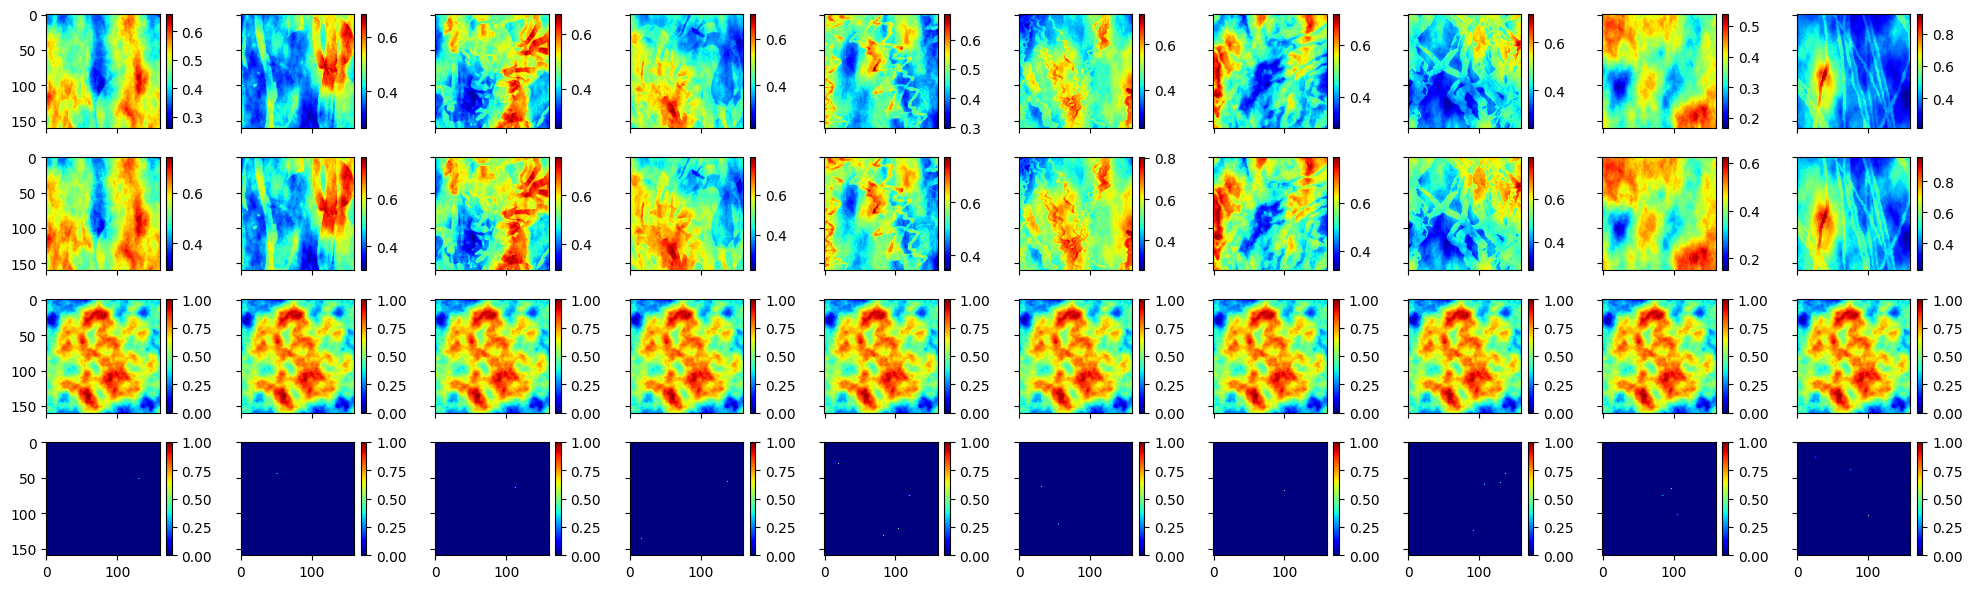

In [9]:
fig, axs = plt.subplots(4, 10, figsize=(20,6), sharex=True, sharey=True)
for i in range(4):
    for j in range(10):
        ax = axs[i,j]
        im = ax.imshow(X_train[j,:,:,i], cmap='jet')
        plt.colorbar(im, pad=0.04, fraction=0.046)
plt.tight_layout()
plt.show()

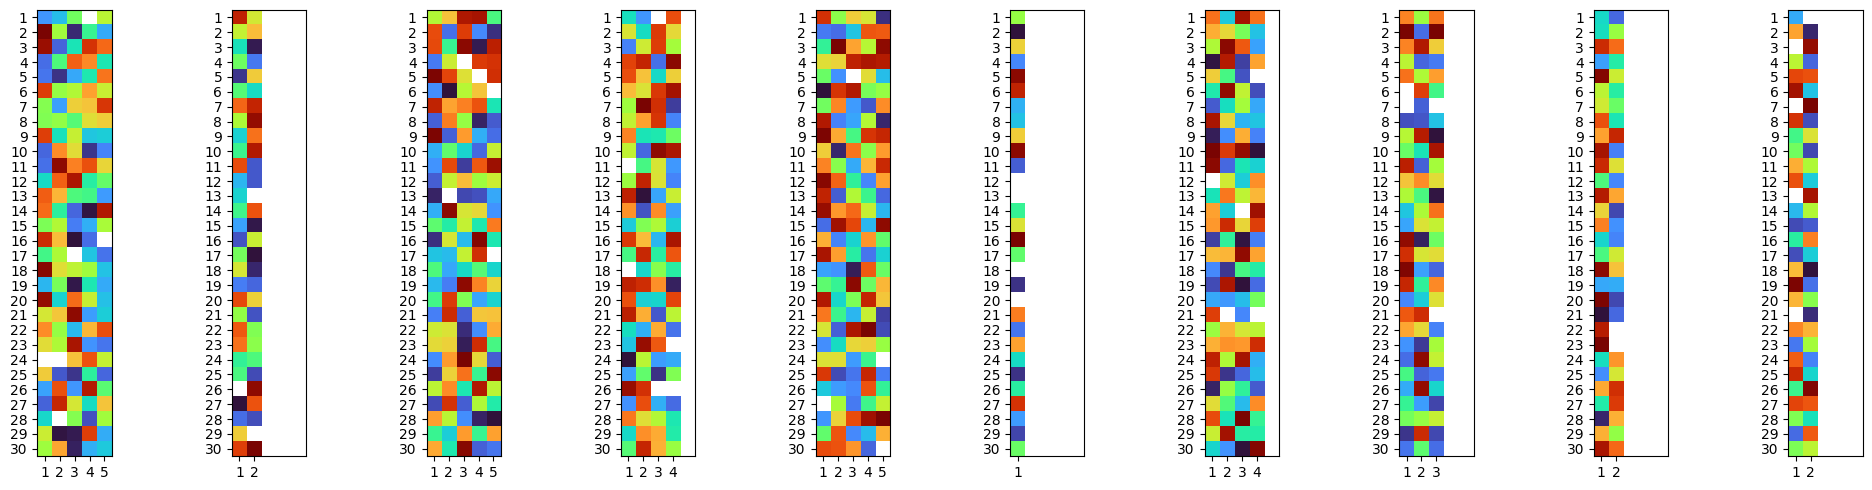

In [28]:
fig, axs = plt.subplots(1, 10, figsize=(20,5))
for j in range(10):
    ax = axs[j]
    cc = c_data[j]
    nc = len(np.nonzero(np.sum(cc,0))[0])
    cm = np.ma.masked_where(cc == 0, cc)
    im = ax.imshow(cm, cmap='turbo')
    ax.set_xticks(range(nc), labels=np.arange(1,nc+1))
    ax.set_yticks(range(30), labels=np.arange(1,31))
plt.tight_layout()
plt.show()

In [29]:
class SqueezeExcite(Layer):
    def __init__(self, ratio=4, **kwargs):
        super(SqueezeExcite, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D()
        self.excite1 = layers.Dense(channels // self.ratio, activation='relu')
        self.excite2 = layers.Dense(channels, activation='sigmoid')
        super(SqueezeExcite, self).build(input_shape)

    def call(self, inputs):
        se_tensor = self.squeeze(inputs)
        se_tensor = self.excite1(se_tensor)
        se_tensor = self.excite2(se_tensor)
        se_tensor = layers.Reshape((1, 1, se_tensor.shape[-1]))(se_tensor)
        scaled_inputs = layers.Multiply()([inputs, se_tensor])
        return layers.Add()([inputs, scaled_inputs])
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [30]:
def encoder_layer(inp, filt, k=3, pad='same', drop=0.1, pool=(2,2)):
    _ = layers.SeparableConv2D(filt, k, padding=pad, activity_regularizer=regularizers.l1(1e-6))(inp)
    _ = SqueezeExcite()(_)
    _ = layers.GroupNormalization(groups=-1)(_)
    _ = layers.PReLU()(_)
    _ = layers.MaxPooling2D(pool)(_)
    #_ = layers.SpatialDropout2D(drop)(_)
    return _

In [31]:
def lifting_layer(inp, dim, drop=0.1, nonlinearity='gelu'):
    _ = layers.Dense(dim)(inp)
    _ = layers.Activation(nonlinearity)(_)
    #_ = layers.Dropout(drop)(_)
    return _

In [32]:
def recurrent_step(inp, filt, res, kern=3, pad='same', drop=0.0, leaky_slope=0.3):
    y = layers.ConvLSTM2D(filt, kern, padding=pad)(inp)
    y = layers.GroupNormalization(groups=-1)(y)
    y = layers.LeakyReLU(leaky_slope)(y)
    y = layers.Conv2DTranspose(filt, kern, padding=pad, strides=2)(y)
    #y = layers.SpatialDropout2D(drop)(y)
    y = layers.Concatenate()([y, res])
    y = layers.Conv2D(filt, kern, padding=pad)(y)
    y = layers.Activation('sigmoid')(y)
    y = tf.expand_dims(y,1)
    return y

def recurrent_last(inp, filt, kern=3, pad='same', drop=0.0, leaky_slope=0.3, out_channels=2):
    y = layers.ConvLSTM2D(filt, kern, padding=pad)(inp)
    y = layers.GroupNormalization(groups=-1)(y)
    y = layers.LeakyReLU(leaky_slope)(y)
    y = layers.Conv2DTranspose(filt, kern, padding=pad, strides=2)(y)
    #y = layers.SpatialDropout2D(drop)(y)
    y = layers.Conv2D(out_channels, kern, padding=pad)(y)
    y = layers.Activation('sigmoid')(y)
    y = tf.expand_dims(y, 1)
    return y

def conditional_recurrent_decoder(z_input, c_input, residuals, rnn_filters=[16,64,256], 
                                  previous_timestep=None, dropout=0.1, leaky_slope=0.3, out_channels:int=2):
    zz = tf.expand_dims(z_input, 1)
    cc = tf.expand_dims(c_input, 1)
    _ = tf.einsum('bthwc,btc->bthwc', zz, cc)
    _ = recurrent_step(_, rnn_filters[0], residuals[0], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_step(_, rnn_filters[1], residuals[1], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_last(_, rnn_filters[2], drop=dropout, leaky_slope=leaky_slope, out_channels=out_channels)
    if previous_timestep is not None:
        _ = layers.Concatenate(axis=1)([previous_timestep, _])
    return _

def unconditional_recurrent_decoder(z_input, residuals, rnn_filters=[16,64,256], 
                                    previous_timestep=None, dropout=0.1, leaky_slope=0.3, out_channels:int=2):    
    _ = tf.expand_dims(z_input, 1)
    _ = recurrent_step(_, rnn_filters[0], residuals[0], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_step(_, rnn_filters[1], residuals[1], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_last(_, rnn_filters[2], drop=dropout, leaky_slope=leaky_slope, out_channels=out_channels)
    if previous_timestep is not None:
        _ = layers.Concatenate(axis=1)([previous_timestep, _])
    return _

In [33]:
def make_model(timesteps=20, verbose:bool=True):
    x_inp = layers.Input(shape=(NX, NY, X_CHANNELS))
    c_inp = layers.Input(shape=(timesteps, 5))

    x1 = encoder_layer(x_inp, 16)
    x2 = encoder_layer(x1, 64)
    x3 = encoder_layer(x2, 256)
    cc = lifting_layer(c_inp, 256)
    t1 = None
    for t in range(timesteps):
        if t==0:
            t1 = conditional_recurrent_decoder(x3, cc[:,t], [x2, x1])
        else:
            t1 = conditional_recurrent_decoder(x3, cc[:,t], [x2, x1], previous_timestep=t1) 

    model = Model(inputs=[x_inp, c_inp], outputs=t1)

    if verbose:
        print('# parameters: {:,}'.format(model.count_params()))
    
    return model

In [36]:
def custom_loss(true, pred, alpha=0.8, beta=0.8, gamma=1.0):

    # perceptual loss
    ssim_loss = tf.reduce_mean(1.0 - tf.image.ssim(true, pred, max_val=1.0))
    psnr_loss = tf.reduce_mean(1.0 / tf.image.psnr(true, pred, max_val=1.0))
    perceptual = gamma * ssim_loss + (1 - gamma) * psnr_loss
    
    # reconstruction loss
    mse_loss = tf.reduce_mean(tf.square(true - pred))
    mae_loss = tf.reduce_mean(tf.abs(true - pred))
    reconstruction = beta * mse_loss + (1 - beta) * mae_loss
    
    # total loss
    return alpha * reconstruction + (1 - alpha) * perceptual

In [37]:
class MonitorCallback(Callback):
    def __init__(self, monitor:int=10):
        super(MonitorCallback, self).__init__()
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.monitor == 0:
            print('Epoch: {} | Loss: {:.5f} | Val Loss: {:.5f}'.format(epoch+1, logs['loss'], logs['val_loss']))

In [38]:
model = make_model()
optimizer = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-6)
model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mse'])

esCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
mcCallback = keras.callbacks.ModelCheckpoint('pix2vid-opt.keras', monitor='val_accuracy', save_best_only=True)
customCBs  = [MonitorCallback(monitor=10)] #, esCallback, mcCallback]

2024-08-17 10:05:39.047049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-17 10:05:39.047199: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-17 10:05:39.047241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-17 10:05:40.131225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-17 10:05:40.131362: I external/local_xla/xla/stream_executor

KeyboardInterrupt: 

In [ ]:
start = time()
fit = model.fit(x=[X_train, c_train], y=[y1_train],
                batch_size       = 4,
                epochs           = 100,
                validation_split = 0.2,
                shuffle          = True,
                callbacks        = customCBs,
                verbose          = 1)
print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
model.save('pix2vid-opt.keras')
pd.DataFrame(fit.history).to_csv('pix2vid-opt.csv', index=False)